In [0]:
'''
# mounts Google Drive to the Colab VM
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

# project github foldername
FOLDERNAME = '/content/drive/My Drive/CS231N/Project/RainfallNowcasting/MovingMNIST/'

# load python files from foldername
import sys
sys.path.append(FOLDERNAME)

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
'''

In [41]:
# Useful libraries
import numpy as np
import math as ma
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from google.colab import files
import csv
%matplotlib inline
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 3

# Download Moving-MNIST dataset
!wget 'http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy'

--2020-05-20 00:14:35--  http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 819200096 (781M)
Saving to: ‘mnist_test_seq.npy.1’

mnist_test_seq.npy. 100%[===================>] 781.25M  13.1MB/s    in 62s     

2020-05-20 00:15:37 (12.6 MB/s) - ‘mnist_test_seq.npy.1’ saved [819200096/819200096]



In [0]:
#
# Parameters
#
loss = 'binary_crossentropy'
optimizer = tf.keras.optimizers.Adam(lr=5e-4)
activ = 'relu'
init = 'he_normal'
nk = 128
ks = 5
lks = 3
#
Ninput = 10
Noutput = 5
Nsample = 500
bs = 12
ep = 20

In [43]:
#
# Data processing
#
def split_data(dataset, n):
  data = np.load(dataset, mmap_mode='r')
  train = data[:, :n, :, :]
  test = data[:, n:n+n//10, :, :]
  return train, test
def preprocess(data):
  data = data.swapaxes(0, 1) # swap frames and instances for tf handling
  data = np.expand_dims(data, -1) # add channel dimension for tf handling (channel=1, ie grayscale)
  data = data/np.amax(data) # minmax normalize data
  data = tf.cast(data, tf.float32) # convert to float32 for tf handling
  return data
def make_XY(data, Ninput, Noutput):
  X = data[:, :Ninput, :, :, :]
  y = data[:, Ninput:Ninput+Noutput, :, :, :]
  return X, y
data_train, data_test = split_data('mnist_test_seq.npy', Nsample)
data_train = preprocess(data_train)
data_test = preprocess(data_test)
N, F, H, W, C = data_train.shape
X, y = make_XY(data_train, Ninput, Noutput)
Xtest, ytest = make_XY(data_test, Ninput, Noutput)
print('data_train (instance, frame, height, width, channel) = '+str(data_train.shape))
print('data_test (instance, frame, height, width, channel) = '+str(data_test.shape))

data_train (instance, frame, height, width, channel) = (500, 20, 64, 64, 1)
data_test (instance, frame, height, width, channel) = (50, 20, 64, 64, 1)


In [0]:
# Model Architecture
def model_init(): 
    inputs = tf.keras.Input(shape=[None, H, W, C])
    # Encoder
    CL1, cl1_h, cl1_c = tf.keras.layers.ConvLSTM2D(nk, ks, padding='same', 
                                                   activation=activ, kernel_initializer=init,
                                                   return_sequences=True, return_state=True)(inputs)
    CL2, cl2_h, cl2_c = tf.keras.layers.ConvLSTM2D(nk, ks, padding='same',
                                                   activation=activ, kernel_initializer=init,
                                                   return_state=True)(CL1)
    # Decoder
    CL3 = tf.keras.layers.ConvLSTM2D(nk, ks, padding='same',
                                     activation=activ, kernel_initializer=init,
                                     return_sequences=True,)(tf.zeros([Noutput, H, W, nk])[None, :, :, :, :],
                                                             initial_state=[cl1_h, cl1_c])
    CL4 = tf.keras.layers.ConvLSTM2D(nk, ks, padding='same',
                                     activation=activ, kernel_initializer=init,
                                     return_sequences=True,)(CL3, initial_state=[cl2_h, cl2_c])
    # Prediction
    concat = tf.keras.layers.Concatenate()([CL3, CL4])
    preds = tf.keras.layers.Conv3D(1, lks, padding='same', 
                                   bias_initializer=tf.keras.initializers.Constant(value=-np.log(99)),
                                   activation='sigmoid')(concat)
    return tf.keras.Model(inputs=inputs, outputs=preds)

In [45]:
'''
# Learning rate step decay
def step_decay(epoch):
   initial_lr = 5e-4
   drop = 0.5
   epochs_drop = 5.0
   lr = initial_lr * ma.pow(drop, ma.floor((1+epoch)/epochs_drop))
   return lr
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)
callbacks_list = [lrate]
'''

'\n# Learning rate step decay\ndef step_decay(epoch):\n   initial_lr = 5e-4\n   drop = 0.5\n   epochs_drop = 5.0\n   lr = initial_lr * ma.pow(drop, ma.floor((1+epoch)/epochs_drop))\n   return lr\nlrate = tf.keras.callbacks.LearningRateScheduler(step_decay)\ncallbacks_list = [lrate]\n'

In [0]:
# Custom metrics

def ssim(y_gt, y_pred, max_val=1.):
  return tf.image.ssim(y_gt, y_pred, max_val)

def psnr(y_gt, y_pred, max_val=1.):
  return tf.image.psnr(y_gt, y_pred, max_val)

def cor(y_gt, y_pred):
  return tfp.stats.correlation(y_gt, y_pred, sample_axis=None, event_axis=None)

In [47]:
# Initialize model
model = model_init()

# Build optimizer
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['acc', 'mse', ssim, psnr, cor,
                       tf.keras.metrics.Precision(name='prec'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.FalseNegatives(name='FN'), 
                       tf.keras.metrics.FalsePositives(name='FP'),
                       tf.keras.metrics.TrueNegatives(name='TN'), 
                       tf.keras.metrics.TruePositives(name='TP')])

# Fit the model
csv_logger = tf.keras.callbacks.CSVLogger('train_results.csv')
history = model.fit(X, y, 
                    batch_size=bs, epochs=ep, 
                    callbacks=[csv_logger],
                    validation_split=0.1)
#files.download('training_results.csv')

# Save it
#model.save('model.h5')
#files.download('model.h5')

# Get results on test set
results = model.evaluate(Xtest, ytest, batch_size=bs, return_dict=True)
with open('test_results.csv', 'w') as f:
    w = csv.DictWriter(f, results.keys())
    w.writeheader()
    w.writerow(results)
#files.download('test_results.csv')

Epoch 1/20
38/38 [==============================] - 109s 3s/step - loss: 0.2578 - acc: 0.9243 - mse: 0.0429 - ssim: 0.2312 - psnr: 14.0073 - cor: 0.1864 - prec: 0.2013 - recall: 0.0151 - FN: 649186.0000 - FP: 39408.0000 - TN: 8517474.0000 - TP: 9932.0000 - val_loss: 0.1581 - val_acc: 0.9311 - val_mse: 0.0342 - val_ssim: 0.1013 - val_psnr: 14.7953 - val_cor: 0.3301 - val_prec: 0.7032 - val_recall: 0.0291 - val_FN: 67796.0000 - val_FP: 858.0000 - val_TN: 953313.0000 - val_TP: 2033.0000
Epoch 2/20
38/38 [==============================] - 104s 3s/step - loss: 0.1546 - acc: 0.9268 - mse: 0.0345 - ssim: 0.1607 - psnr: 14.8013 - cor: 0.3921 - prec: 0.6805 - recall: 0.0558 - FN: 622330.0000 - FP: 17276.0000 - TN: 8539606.0000 - TP: 36788.0000 - val_loss: 0.1390 - val_acc: 0.9289 - val_mse: 0.0318 - val_ssim: 0.3126 - val_psnr: 15.1545 - val_cor: 0.4338 - val_prec: 0.6630 - val_recall: 0.0984 - val_FN: 62957.0000 - val_FP: 3493.0000 - val_TN: 950678.0000 - val_TP: 6872.0000
Epoch 3/20
38/38 [==

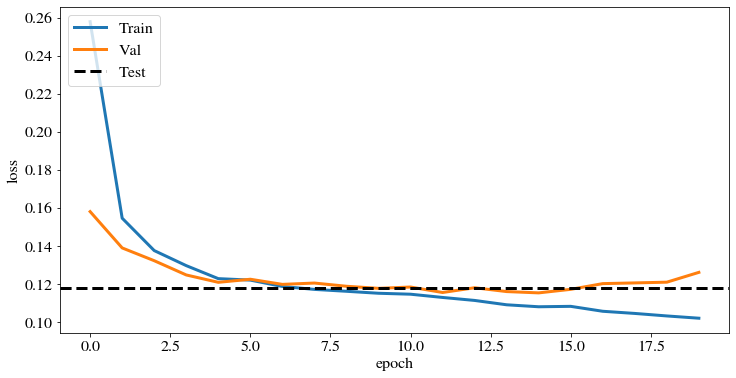

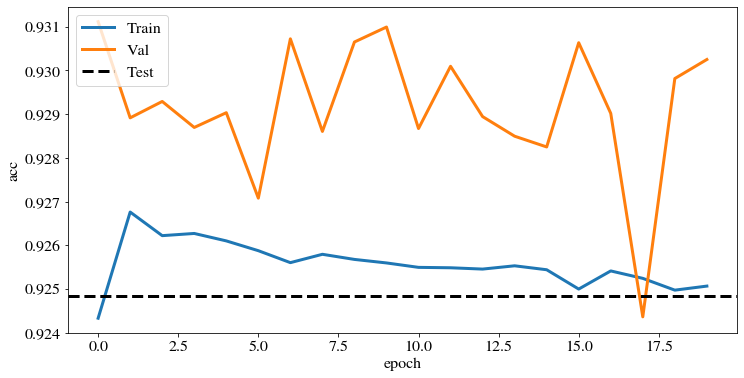

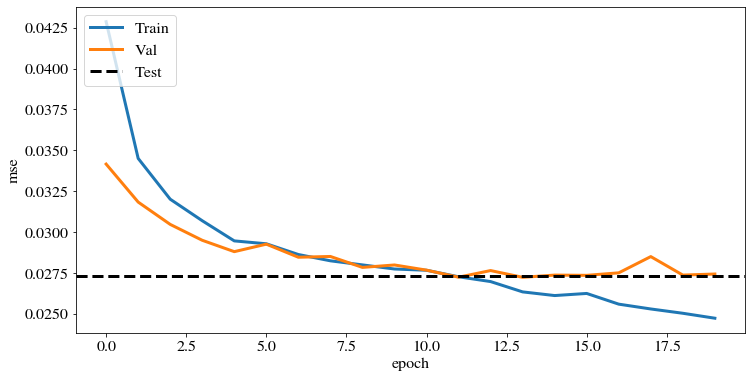

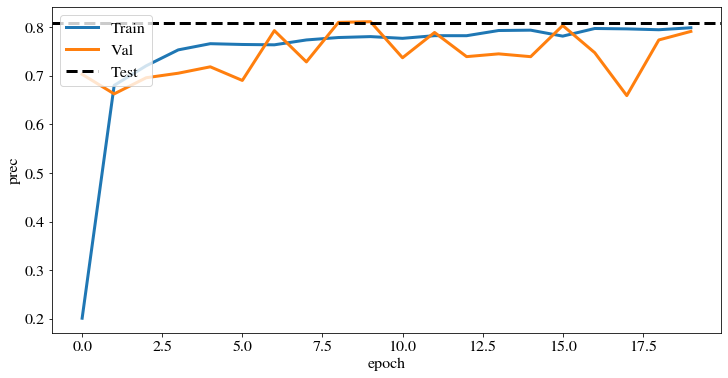

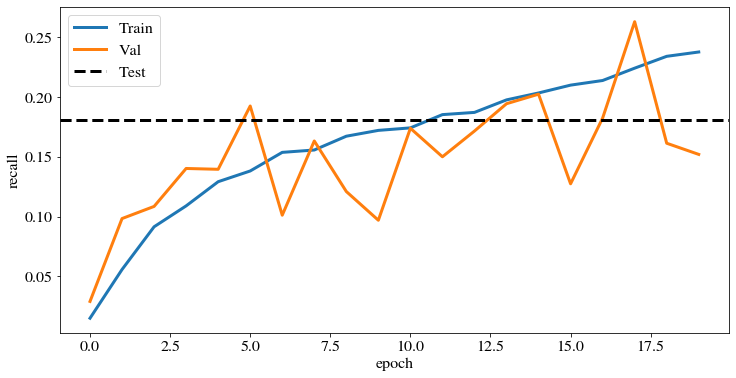

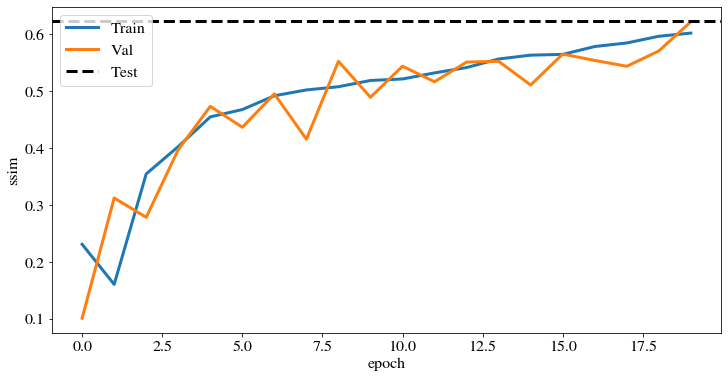

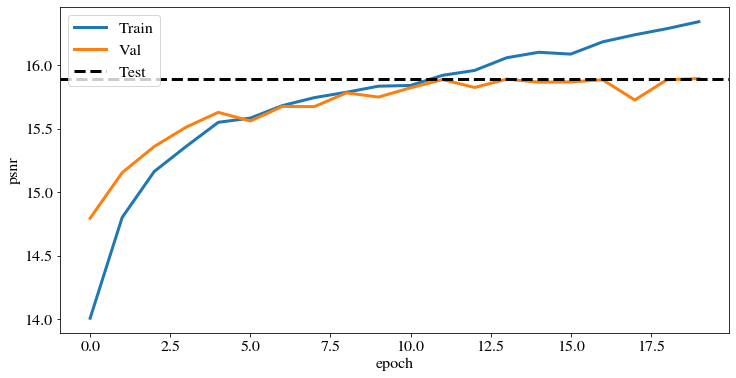

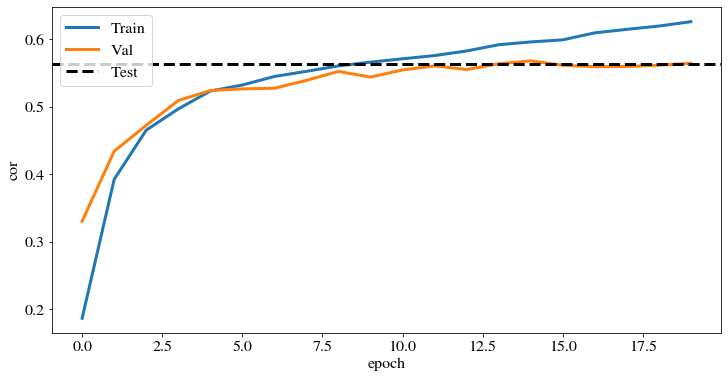

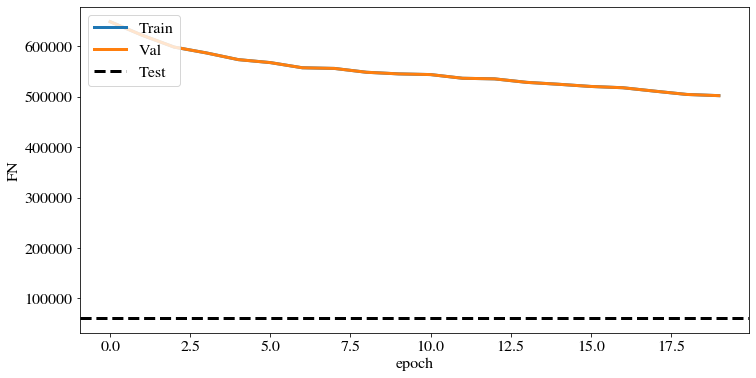

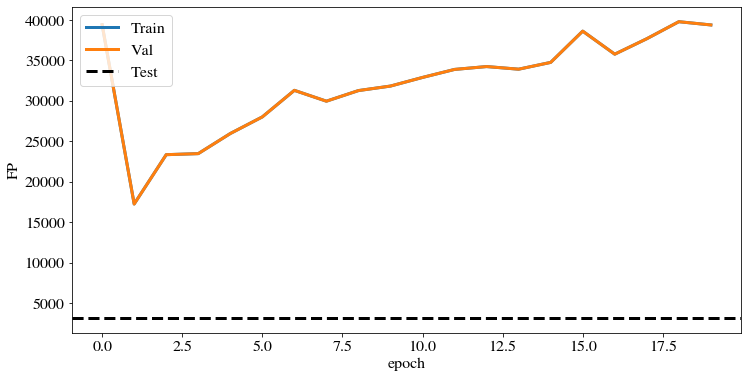

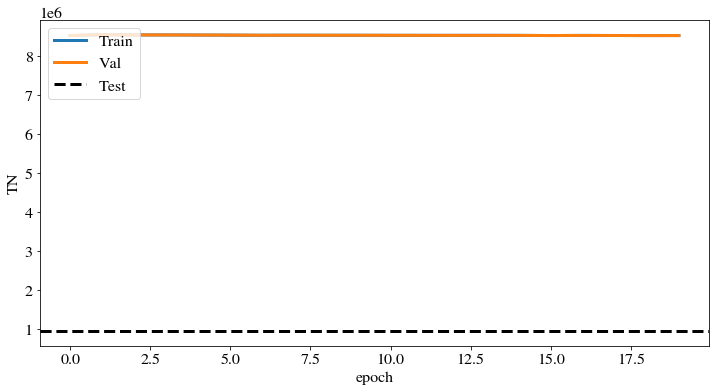

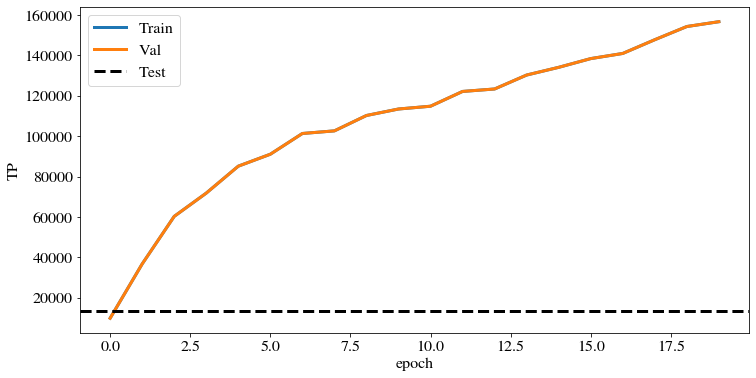

In [48]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.axhline(results['loss'], linestyle='--', color='k', label='Test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss.png')
#files.download('loss.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Val')
plt.axhline(results['acc'], linestyle='--', color='k', label='Test')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('acc.png')
#files.download('acc.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['mse'], label='Train')
plt.plot(history.history['val_mse'], label='Val')
plt.axhline(results['mse'], linestyle='--', color='k', label='Test')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('mse.png')
#files.download('mse.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['prec'], label='Train')
plt.plot(history.history['val_prec'], label='Val')
plt.axhline(results['prec'], linestyle='--', color='k', label='Test')
plt.ylabel('prec')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('prec.png')
#files.download('prec.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['recall'], label='Train')
plt.plot(history.history['val_recall'], label='Val')
plt.axhline(results['recall'], linestyle='--', color='k', label='Test')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('recall.png')
#files.download('recall.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['ssim'], label='Train')
plt.plot(history.history['val_ssim'], label='Val')
plt.axhline(results['ssim'], linestyle='--', color='k', label='Test')
plt.ylabel('ssim')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('ssim.png')
#files.download('ssim.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['psnr'], label='Train')
plt.plot(history.history['val_psnr'], label='Val')
plt.axhline(results['psnr'], linestyle='--', color='k', label='Test')
plt.ylabel('psnr')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('psnr.png')
#files.download('psnr.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['cor'], label='Train')
plt.plot(history.history['val_cor'], label='Val')
plt.axhline(results['cor'], linestyle='--', color='k', label='Test')
plt.ylabel('cor')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('cor.png')
#files.download('cor.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['FN'], label='Train')
plt.plot(history.history['FN'], label='Val')
plt.axhline(results['FN'], linestyle='--', color='k', label='Test')
plt.ylabel('FN')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('FN.png')
#files.download('FN.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['FP'], label='Train')
plt.plot(history.history['FP'], label='Val')
plt.axhline(results['FP'], linestyle='--', color='k', label='Test')
plt.ylabel('FP')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('FP.png')
#files.download('FP.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['TN'], label='Train')
plt.plot(history.history['TN'], label='Val')
plt.axhline(results['TN'], linestyle='--', color='k', label='Test')
plt.ylabel('TN')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('TN.png')
#files.download('TN.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['TP'], label='Train')
plt.plot(history.history['TP'], label='Val')
plt.axhline(results['TP'], linestyle='--', color='k', label='Test')
plt.ylabel('TP')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('TP.png')
#files.download('TP.png')

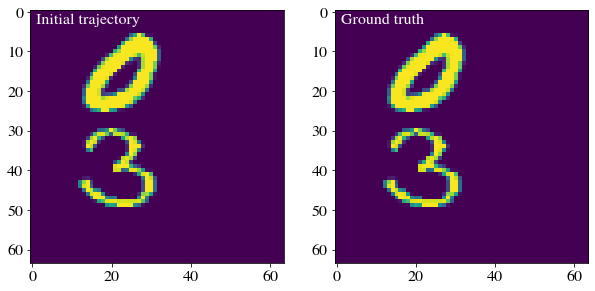

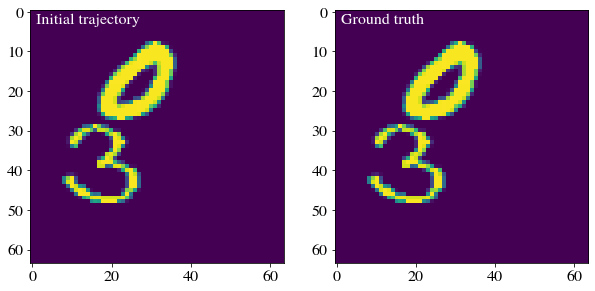

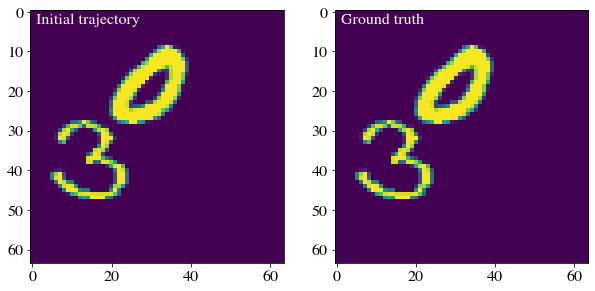

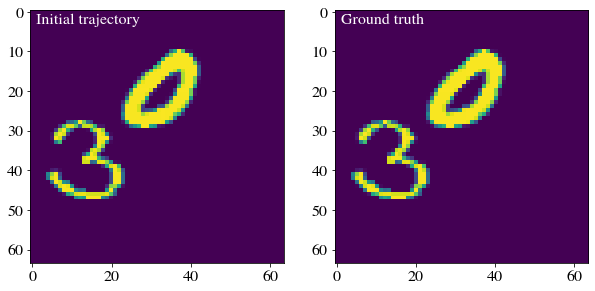

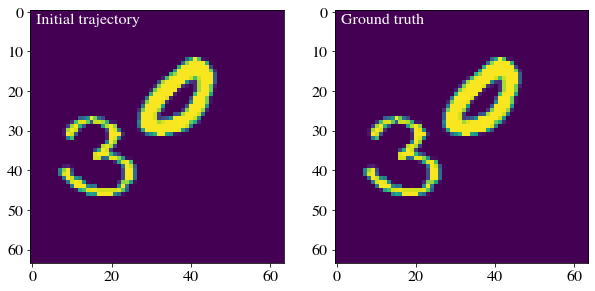

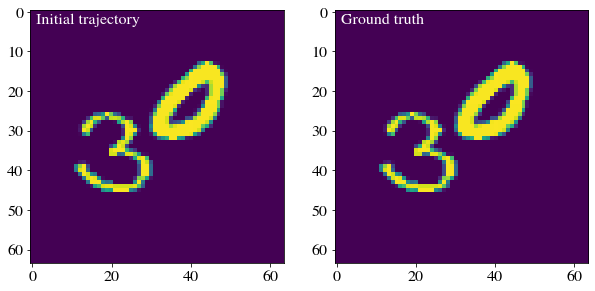

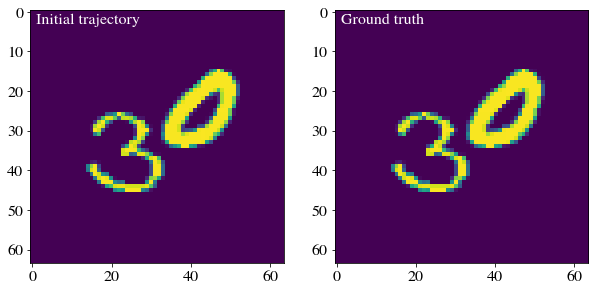

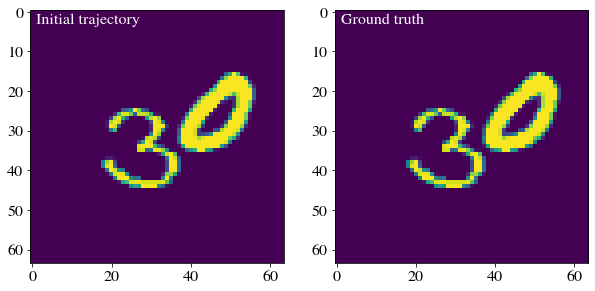

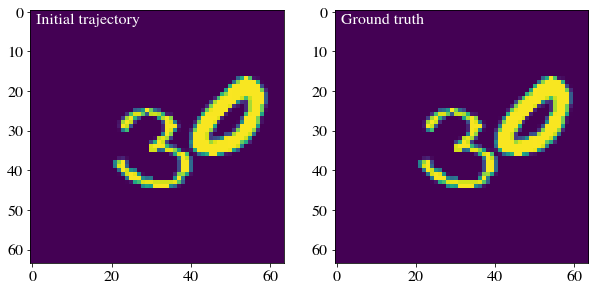

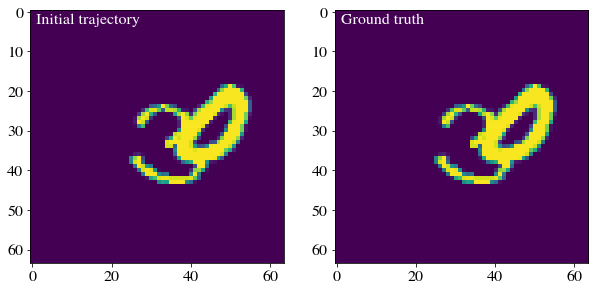

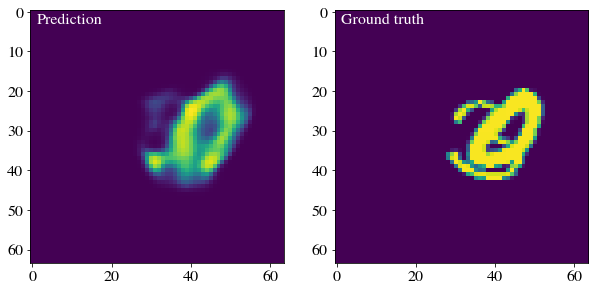

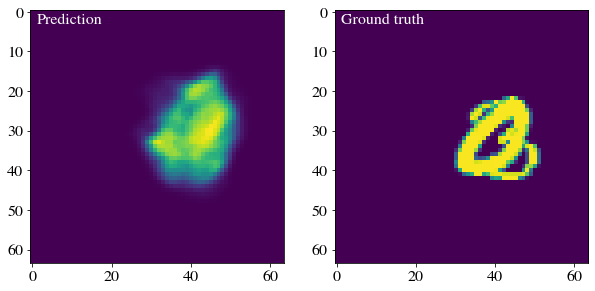

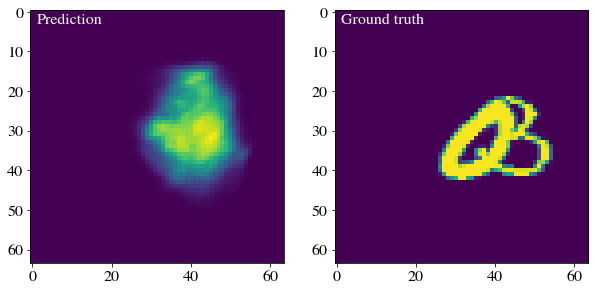

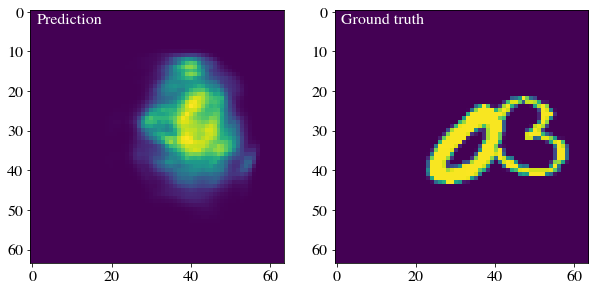

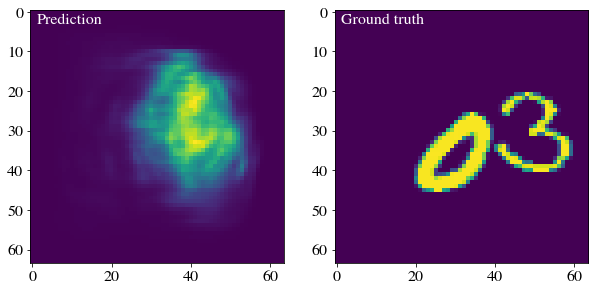

In [49]:
# Plot Train
itest = 1
track = X[itest, :, :, :, :]
track = np.concatenate((track[None,:,:,:,:], model.predict(track[None,:,:,:,:])), axis=1)
true_track = data_train[itest, :, :, :, :]
for i in range(Ninput+Noutput):
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    if i >= Ninput:
        plt.text(1, 3, 'Prediction', color='w')
    else:
        plt.text(1, 3, 'Initial trajectory', color='w')
    plt.imshow(track[0, i, :, :, 0])
    plt.subplot(122)
    plt.text(1, 3, 'Ground truth', color='w')
    plt.imshow(true_track[i, :, :, 0])
    plt.savefig('train_%i.png' % (i+1))
    #files.download('train_%i.png' % (i+1))

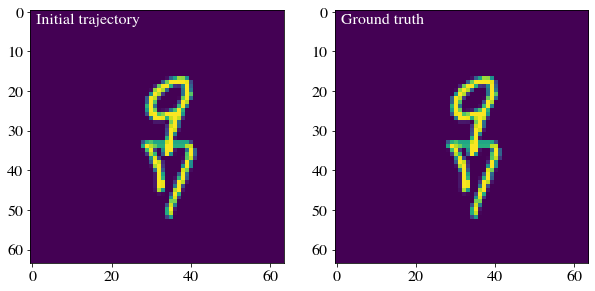

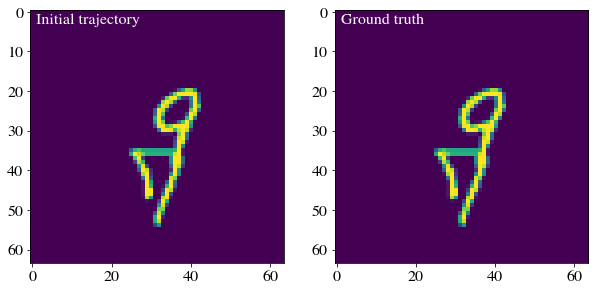

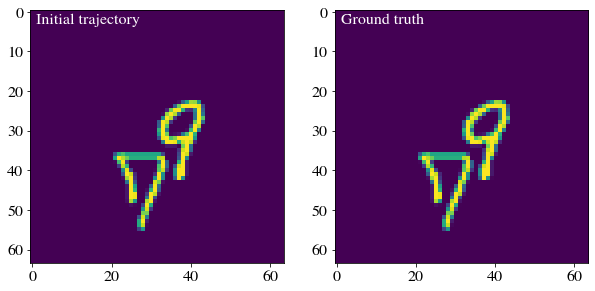

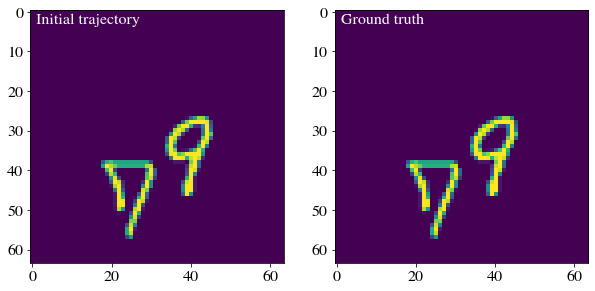

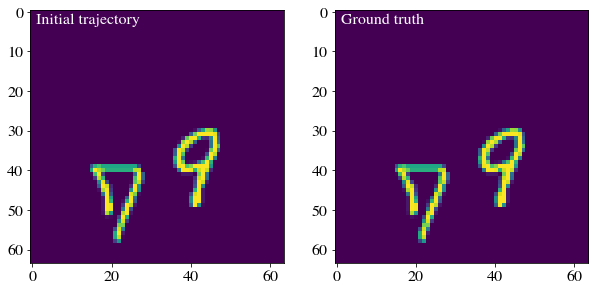

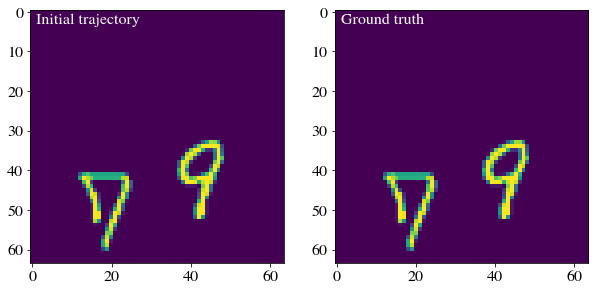

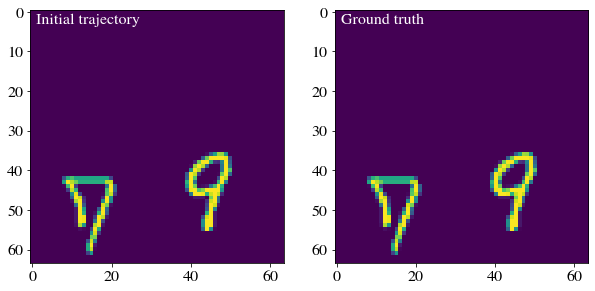

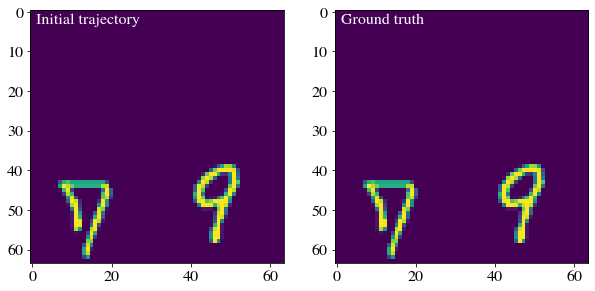

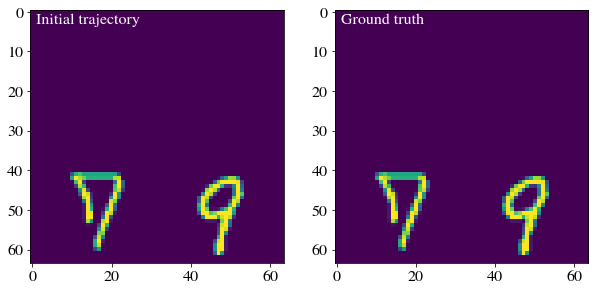

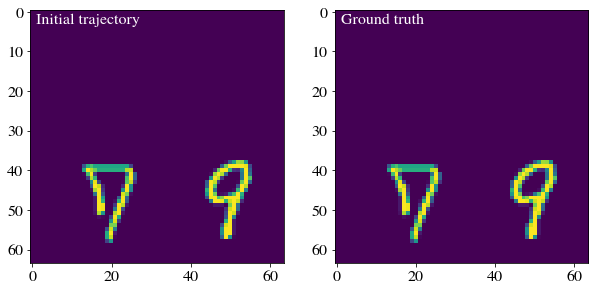

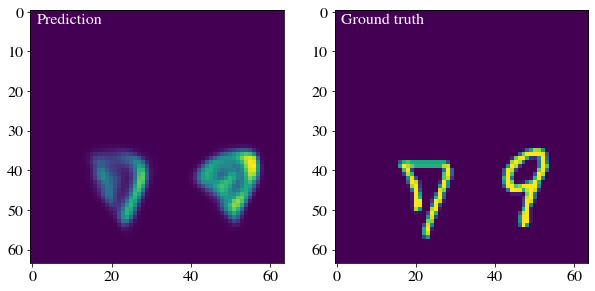

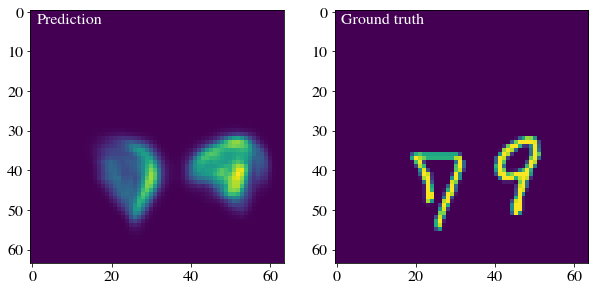

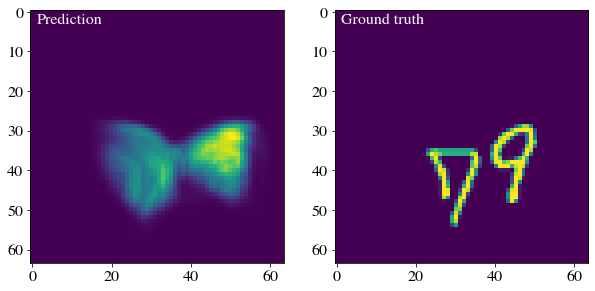

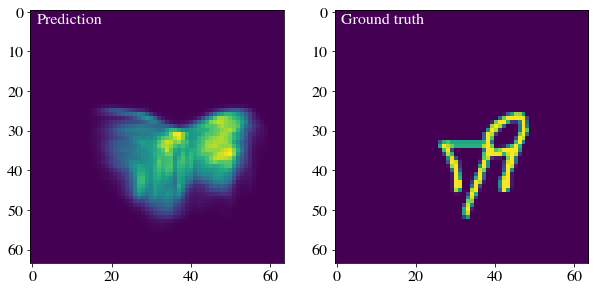

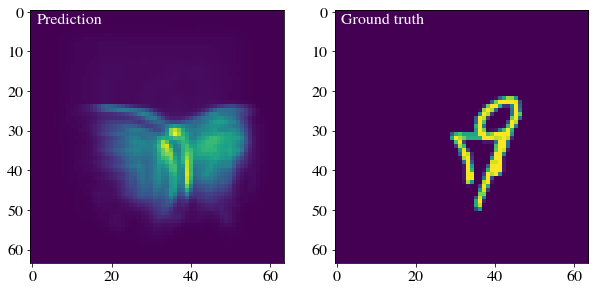

In [50]:
# Plot Test
itest = 1
track = Xtest[itest, :, :, :, :]
track = np.concatenate((track[None,:,:,:,:], model.predict(track[None,:,:,:,:])), axis=1)
true_track = data_test[itest, :, :, :, :]
for i in range(Ninput+Noutput):
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    if i >= Ninput:
        plt.text(1, 3, 'Prediction', color='w')
    else:
        plt.text(1, 3, 'Initial trajectory', color='w')
    plt.imshow(track[0, i, :, :, 0])
    plt.subplot(122)
    plt.text(1, 3, 'Ground truth', color='w')
    plt.imshow(true_track[i, :, :, 0])
    plt.savefig('test_%i.png' % (i+1))
    #files.download('test_%i.png' % (i+1))